<a href="https://colab.research.google.com/github/Mkhan13/ai_cybersecurity/blob/Assignment-1/Cybersec_Lab_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interactive Clustering Exploration Lab
**CYBERSEC 520: Hands-On Clustering & Anomaly Detection**

## Lab Objectives
- **Explore** how different parameters affect clustering
- **Compare** K-Means, GMM, and DBSCAN algorithms
- **Analyze** real cybersecurity datasets
- **Discover** optimal cluster numbers for different scenarios

---

**Name:** Mariam Khan

## Setup and Imports

In [17]:
# Essential imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Plotting setup
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("husl")

print("Setup complete! Ready to explore clustering!")

Setup complete! Ready to explore clustering!


In [18]:
# Mount Google Drive for dataset access
from google.colab import drive
drive.mount('/content/drive')

print("Google Drive mounted successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive mounted successfully!


---

## Part 1: Synthetic Data Generation

### Run the Following cell

In [19]:
def generate_clustering_data(n_samples, n_centers, cluster_std,
                            anomaly_fraction, noise_level):
    """
    Generate synthetic data for clustering experiments

    Parameters:
    - n_samples: Total number of data points
    - n_centers: Number of true clusters
    - cluster_std: Standard deviation of clusters (tightness)
    - anomaly_fraction: Fraction of points to make anomalous
    - noise_level: Amount of random noise to add
    """
    # Generate main clusters
    normal_samples = int(n_samples * (1 - anomaly_fraction))
    X_normal, y_true = make_blobs(n_samples=normal_samples, centers=n_centers,
                                  cluster_std=cluster_std)

    # Add noise to normal data
    X_normal += np.random.normal(0, noise_level, X_normal.shape)

    # Generate anomalous points
    anomaly_samples = int(n_samples * anomaly_fraction)
    if anomaly_samples > 0:
        # Anomalies are far from clusters
        anomaly_range = [X_normal.min() - 3, X_normal.max() + 3]
        X_anomaly = np.random.uniform(anomaly_range[0], anomaly_range[1],
                                     (anomaly_samples, 2))

        # Combine normal and anomalous data
        X = np.vstack([X_normal, X_anomaly])
        labels = np.hstack([np.zeros(normal_samples), np.ones(anomaly_samples)])
        cluster_labels = np.hstack([y_true, [-1] * anomaly_samples])
    else:
        X = X_normal
        labels = np.zeros(normal_samples)
        cluster_labels = y_true
        print("No anomalies generated.")

    return X, labels, cluster_labels

def plot_data(X, labels, title="Generated Data"):
    """Quick plotting function"""
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.title(title, fontweight='bold', fontsize=14)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(scatter)
    plt.grid(True, alpha=0.3)
    plt.show()

print("Data generation functions ready!")

Data generation functions ready!


### Experiment 1: Play with Parameters!

**GROUP TASK:** Try different parameter combinations and observe how they affect clustering.

**Parameters to Experiment With:**
- `n_centers`: 2, 3, 5, 8 (true number of clusters)
- `cluster_std`: 0.5, 1.0, 2.0, 3.0 (cluster tightness)
- `anomaly_fraction`: 0.0, 0.05, 0.15, 0.25 (percentage of outliers)
- `noise_level`: 0.0, 0.1, 0.5, 1.0 (background noise)


Generated data with 7 true clusters
Data shape: (800, 2)
Anomalies: 40 (5.0%)


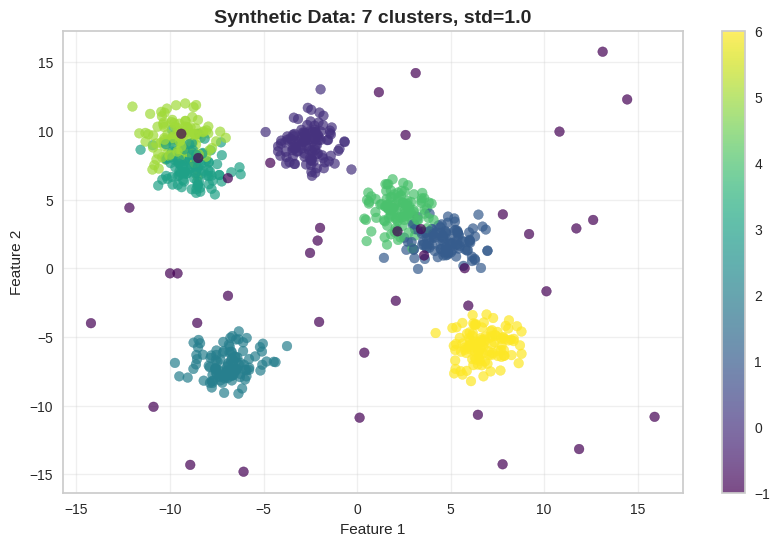


 DISCUSS WITH YOUR GROUP:
1. How does cluster_std affect the data visualization?
2. What happens when anomaly_fraction increases?
3. How does noise_level impact cluster separation?


In [20]:
# EXPERIMENT 1: Modify these parameters and run multiple times!
# Try different combinations and discuss with your group

# MODIFY THESE PARAMETERS:
n_centers = 7          # True number of clusters (try: 2, 3, 5, 8)
cluster_std = 1.0      # Cluster tightness (try: 0.5, 1.0, 2.0, 3.0)
anomaly_fraction = 0.05 # Fraction of outliers (try: 0.0, 0.05, 0.15, 0.25)
noise_level = 0.1     # Background noise (try: 0.0, 0.1, 0.5, 1.0)

# Generate and visualize data
X, anomaly_labels, true_clusters = generate_clustering_data(
    n_samples=800, n_centers=n_centers, cluster_std=cluster_std,
    anomaly_fraction=anomaly_fraction, noise_level=noise_level
)

print(f"Generated data with {n_centers} true clusters")
print(f"Data shape: {X.shape}")
print(f"Anomalies: {np.sum(anomaly_labels == 1)} ({anomaly_fraction*100:.1f}%)")

# Plot the generated data
plot_data(X, true_clusters, f"Synthetic Data: {n_centers} clusters, std={cluster_std}")

# GROUP DISCUSSION QUESTIONS:
print("\n DISCUSS WITH YOUR GROUP:")
print("1. How does cluster_std affect the data visualization?")
print("2. What happens when anomaly_fraction increases?")
print("3. How does noise_level impact cluster separation?")

1.  The greater the value of cluster_std, the less densly clustered the data points are. If you reduce the value of cluster_std, the data points become more tightly clustered.
2.  When anomaly_fraction increases, the number of outliers included on the graph increases
3. The greater the value of noise_level, the more tightly grouped the clusters are. If you reduce the value of noise_level, the clusters become more separated.

---

## Part 2: Quick Clustering Algorithm Comparison

### Compare K-Means, GMM, and DBSCAN on Your Data

In [21]:
def find_optimal_clusters(X, max_k=10, method='both'):
    """Find optimal number of clusters using elbow and silhouette methods"""

    if method in ['elbow', 'both']:
        # Elbow Method
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        model = KMeans(random_state=42)
        visualizer = KElbowVisualizer(model, k=(2, max_k), timings=False)
        visualizer.fit(X)
        visualizer.draw()
        elbow_k = visualizer.elbow_value_
        plt.title('Elbow Method for Optimal k', fontweight='bold')

        if method == 'both':
            plt.subplot(1, 2, 2)

    if method in ['silhouette', 'both']:
        # Silhouette Method
        if method != 'both':
            plt.figure(figsize=(8, 5))

        k_range = range(2, max_k + 1)
        silhouette_scores = []

        for k in k_range:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X)
            silhouette_avg = silhouette_score(X, cluster_labels)
            silhouette_scores.append(silhouette_avg)

        plt.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
        plt.xlabel('Number of clusters (k)')
        plt.ylabel('Silhouette Score')
        plt.title('Silhouette Analysis for Optimal k', fontweight='bold')
        plt.grid(True, alpha=0.3)

        optimal_k_sil = k_range[np.argmax(silhouette_scores)]
        max_silhouette = max(silhouette_scores)

        plt.axvline(x=optimal_k_sil, color='red', linestyle='--',
                   label=f'Optimal k={optimal_k_sil} (score={max_silhouette:.3f})')
        plt.legend()

    plt.tight_layout()
    plt.show()

    if method == 'both':
        print(f"Elbow method suggests: k = {elbow_k}")
        print(f"Silhouette method suggests: k = {optimal_k_sil}")
        return elbow_k, optimal_k_sil
    elif method == 'silhouette':
        print(f"Silhouette method suggests: k = {optimal_k_sil}")
        return optimal_k_sil
    else:
        print(f"Elbow method suggests: k = {elbow_k}")
        return elbow_k

def compare_clustering_algorithms(X, k=4):
    """Compare K-Means, GMM, and DBSCAN"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # Original Data
    axes[0, 0].scatter(X[:, 0], X[:, 1], alpha=0.7, s=50)
    axes[0, 0].set_title('Original Data', fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3)

    # K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    silhouette_kmeans = silhouette_score(X, kmeans_labels)

    scatter = axes[0, 1].scatter(X[:, 0], X[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
    axes[0, 1].scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
                      c='red', marker='x', s=200, linewidths=3)
    axes[0, 1].set_title(f'K-Means (k={k})\nSilhouette: {silhouette_kmeans:.3f}', fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)

    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm_labels = gmm.fit_predict(X)
    silhouette_gmm = silhouette_score(X, gmm_labels)

    axes[0, 2].scatter(X[:, 0], X[:, 1], c=gmm_labels, cmap='viridis', alpha=0.7)
    axes[0, 2].set_title(f'GMM (k={k})\nSilhouette: {silhouette_gmm:.3f}', fontweight='bold')
    axes[0, 2].grid(True, alpha=0.3)

    # DBSCAN with different parameters
    eps_values = [0.3, 0.5, 1.0]
    min_samples = 5

    for i, eps in enumerate(eps_values):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan_labels = dbscan.fit_predict(X)

        n_clusters_db = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
        n_noise = list(dbscan_labels).count(-1)

        if len(set(dbscan_labels)) > 1:
            silhouette_db = silhouette_score(X, dbscan_labels) if n_clusters_db > 1 else 0
        else:
            silhouette_db = 0

        axes[1, i].scatter(X[:, 0], X[:, 1], c=dbscan_labels, cmap='viridis', alpha=0.7)
        axes[1, i].set_title(f'DBSCAN (eps={eps})\nClusters: {n_clusters_db}, Noise: {n_noise}\nSilhouette: {silhouette_db:.3f}',
                           fontweight='bold')
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    print(f"\n ALGORITHM COMPARISON SUMMARY:")
    print(f"K-Means (k={k}): Silhouette = {silhouette_kmeans:.3f}")
    print(f"GMM (k={k}): Silhouette = {silhouette_gmm:.3f}")
    print(f"DBSCAN: Try different eps values to find optimal clustering")

    return {
        'kmeans': {'labels': kmeans_labels, 'silhouette': silhouette_kmeans},
        'gmm': {'labels': gmm_labels, 'silhouette': silhouette_gmm}
    }

print("Clustering comparison functions ready!")

Clustering comparison functions ready!


### Experiment 2: Find the Optimal Number of Clusters

**GROUP TASK:** Use your generated data to find the optimal number of clusters.

Finding optimal clusters for data with 7 true clusters...
Your current parameters: std=1.0, anomalies=0.05, noise=0.1


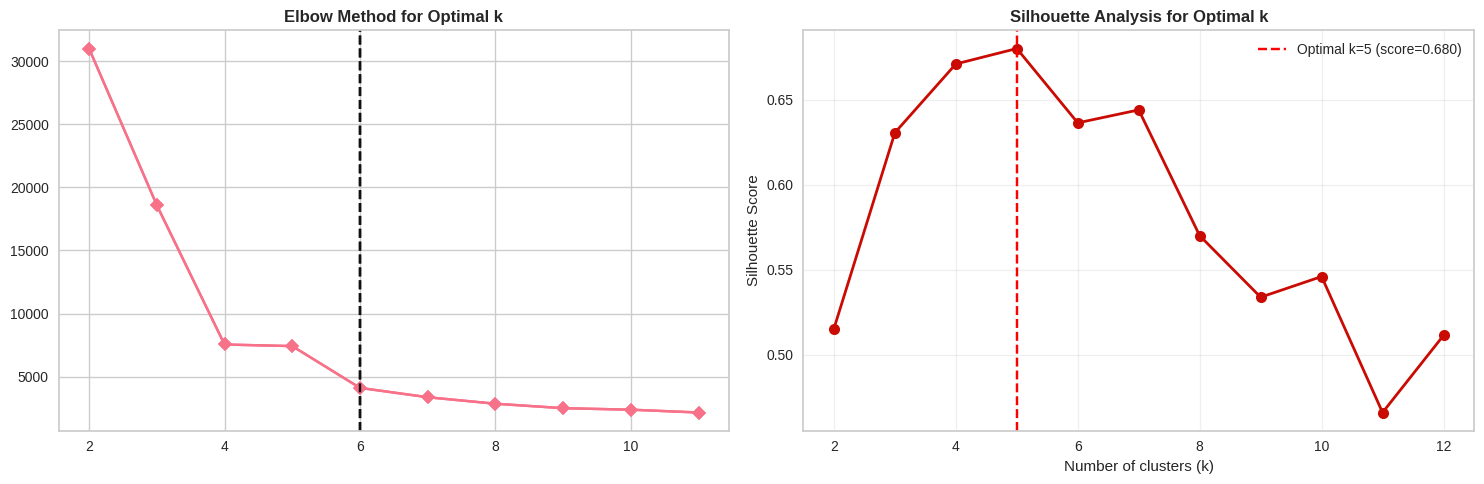

Elbow method suggests: k = 6
Silhouette method suggests: k = 5

RESULTS:
True clusters: 7
Elbow method: 6
Silhouette method: 5

 DISCUSS WITH YOUR GROUP:
1. Do the methods agree on the optimal k?
2. How close are they to the true number of clusters?
3. What factors might cause differences?


In [22]:
# EXPERIMENT 2: Find optimal clusters for your data

print(f"Finding optimal clusters for data with {n_centers} true clusters...")
print(f"Your current parameters: std={cluster_std}, anomalies={anomaly_fraction}, noise={noise_level}")

# Find optimal number of clusters
elbow_k, silhouette_k = find_optimal_clusters(X, max_k=12)

print(f"\nRESULTS:")
print(f"True clusters: {n_centers}")
print(f"Elbow method: {elbow_k}")
print(f"Silhouette method: {silhouette_k}")

# GROUP DISCUSSION:
print("\n DISCUSS WITH YOUR GROUP:")
print("1. Do the methods agree on the optimal k?")
print("2. How close are they to the true number of clusters?")
print("3. What factors might cause differences?")

1. The methods do not agree on the optimal k. The elbow method suggests k = 6 and the silhouette method suggests k = 5.
2. The true number of clusters = 7, so the elbow method is closest is closest to the true number.
3. One factor that might cause differences is the percentage of anomolies included in the data. Any change to the parameters impacts the outcome of both methods.

### Experiment 3: Comparing Algorithms

**GROUP TASK:** Compare how different algorithms handle your data.

Comparing algorithms with k=6...


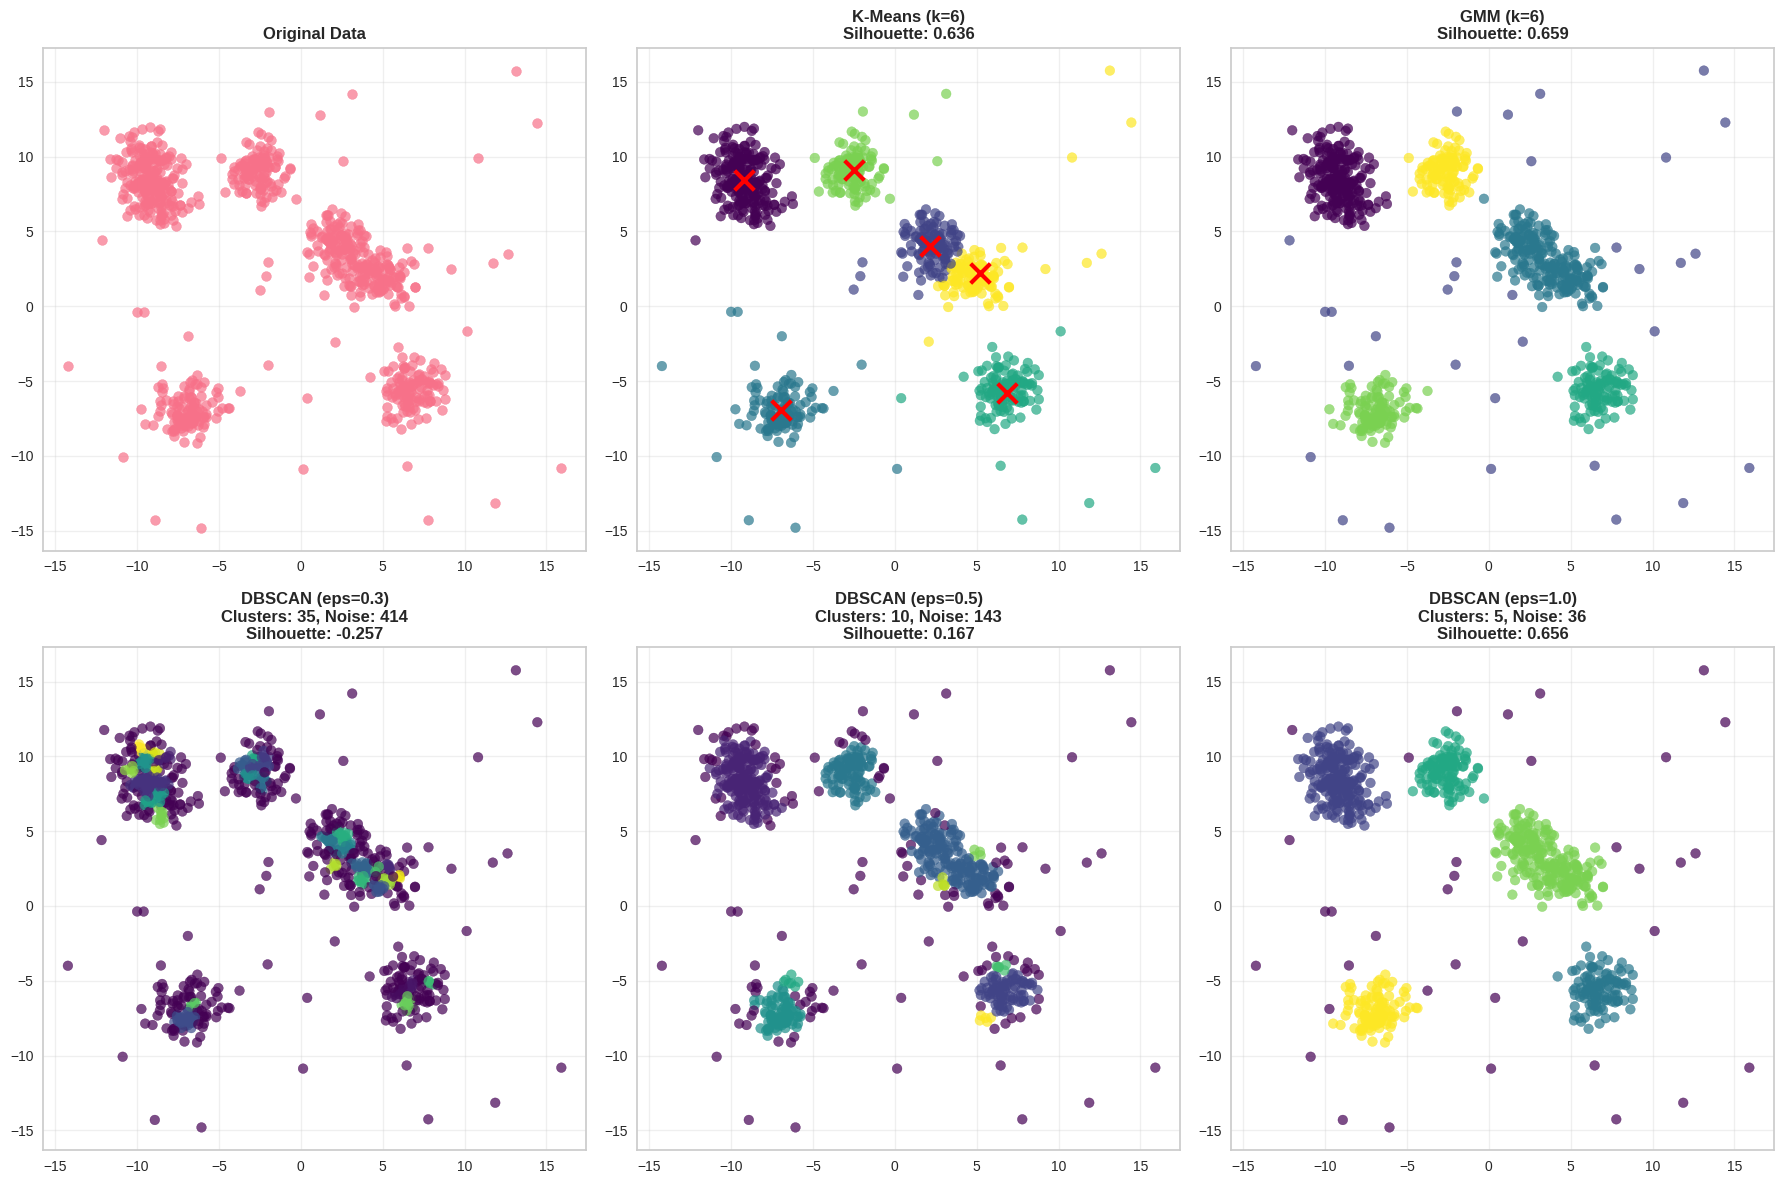


 ALGORITHM COMPARISON SUMMARY:
K-Means (k=6): Silhouette = 0.636
GMM (k=6): Silhouette = 0.659
DBSCAN: Try different eps values to find optimal clustering

 Try different k values by changing 'test_k' above
Suggested values: 6, 7, 8, 9

 DISCUSS WITH YOUR GROUP:
1. Which algorithm performs best on your data?
2. How does DBSCAN handle noise/outliers differently?
3. When might you prefer GMM over K-Means?


In [23]:
# EXPERIMENT 3: Compare clustering algorithms

# Use the optimal k found above (or experiment with different values)
test_k = elbow_k  # You can change this to elbow_k or any other value

print(f"Comparing algorithms with k={test_k}...")

results = compare_clustering_algorithms(X, k=test_k)

# EXPERIMENT: Try different k values!
print(f"\n Try different k values by changing 'test_k' above")
print(f"Suggested values: {max(2, n_centers-1)}, {n_centers}, {n_centers+1}, {n_centers+2}")

# GROUP DISCUSSION:
print("\n DISCUSS WITH YOUR GROUP:")
print("1. Which algorithm performs best on your data?")
print("2. How does DBSCAN handle noise/outliers differently?")
print("3. When might you prefer GMM over K-Means?")

1. Bases on the silhouette scores, the GMM algorithm performs the best when using elbow_k as the value of k.
2. DBSCAN labels noise as outliers while K-Means and GMM assign each noise point to a cluster.
3.  You might prefer GMM over K-Means when the clusters have unique shapes or boundaries. K-Means use circular boundaries while GMM uses elliptical boundaries which captures the shape of unique shaped clusters better.

---

## Part 3: Real Cybersecurity Data Exploration

### Load and Analyze CIC-IDS2017 Dataset

In [24]:
def load_cybersec_data(file_path, sample_size=2000, focus_benign=True):
    """Load and preprocess cybersecurity dataset"""
    try:
        print(f"Loading data from: {file_path}")
        data = pd.read_csv(file_path)
        print(f"Original shape: {data.shape}")

        if ' Label' in data.columns:
            print(f"Labels found: {data[' Label'].value_counts().to_dict()}")

            if focus_benign:
                # Focus only on benign traffic for clustering
                data_benign = data[data[' Label'] == 'BENIGN'].copy()
                print(f"Filtered to benign traffic: {data_benign.shape[0]} samples")
                data = data_benign

        # Select key features
        feature_cols = [
            ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets',
            ' Fwd Packet Length Mean', ' Bwd Packet Length Mean',
            ' Flow Bytes/s', ' Flow Packets/s', ' Fwd Packets/s',
            ' Average Packet Size', ' Fwd Segment Size Avg'
        ]

        available_features = [col for col in feature_cols if col in data.columns]
        print(f"🔧 Using {len(available_features)} features: {available_features[:5]}...")

        # Clean and preprocess
        features_df = data[available_features].copy()
        features_df = features_df.replace([np.inf, -np.inf], np.nan)
        features_df = features_df.dropna()


        # Sample if too large
        if len(features_df) > sample_size:
            features_df = features_df.sample(n=sample_size, random_state=42)
            print(f"Sampled to {sample_size} points")

        # Scale features
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features_df)

        return features_scaled, features_df.columns.tolist(), len(data)

    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None, None

# Available datasets - UPDATE THESE PATHS!  These are the path for my datasets, yours may vary.
datasets = {
    'Monday': '/content/drive/MyDrive/Cybersec/Monday-WorkingHours.pcap_ISCX.csv',
    'Tuesday': '/content/drive/MyDrive/Cybersec/Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday': '/content/drive/MyDrive/Cybersec/Wednesday-workingHours.pcap_ISCX.csv',
    'Thursday_morning': '/content/drive/MyDrive/Cybersec/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Thursday_afternoon': '/content/drive/MyDrive/Cybersec/Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Friday_DDOS': '/content/drive/MyDrive/Cybersec/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday_PortScan': '/content/drive/MyDrive/Cybersec/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday_morning': '/content/drive/MyDrive/Cybersec/Friday-WorkingHours-AfternoonDDos.csv'
}

print("Real data loading functions ready!")
print("Remember to update the file paths above to match your Google Drive structure!")

Real data loading functions ready!
Remember to update the file paths above to match your Google Drive structure!


# Challenge: Real Data

## How Well can you classify real data.  

In [36]:
# TODO: RUN Through Clustering Again with CICIDS Data

print("Challenge 3: Streaming Anomaly Detection")
print("Simulate real-time processing of network traffic")

# Your code here:
# HINT: Process data in small batches
# HINT: Start with Benign Data
# HINT: Use the data loading function above to streamline loading
# OPTIONAL: Use lessons learned in previous notebooks to select features or transform data.


X_scaled, feature_names, total_rows = load_cybersec_data(datasets['Monday'], sample_size=2000, focus_benign=True) # Start with Benign Data
X_baseline = X_scaled[:500]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X_baseline)

batch_size = 250 # Process data in small batches
for i in range(500, len(X_scaled), batch_size):
    batch = X_scaled[i:i + batch_size] # Apply scaling

    distances = np.min(np.linalg.norm(batch[:, None] - kmeans.cluster_centers_, axis=2), axis=1) # Distance to nearest cluster center
    anomalies = distances > distances.mean()

    print(f"{i/batch_size}: {np.sum(anomalies)} anomalies")

Challenge 3: Streaming Anomaly Detection
Simulate real-time processing of network traffic
Loading data from: /content/drive/MyDrive/Cybersec/Monday-WorkingHours.pcap_ISCX.csv
Original shape: (529918, 79)
Labels found: {'BENIGN': 529918}
Filtered to benign traffic: 529918 samples
🔧 Using 7 features: [' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', ' Fwd Packet Length Mean', ' Bwd Packet Length Mean']...
Sampled to 2000 points
2.0: 62 anomalies
3.0: 69 anomalies
4.0: 59 anomalies
5.0: 72 anomalies
6.0: 69 anomalies
7.0: 70 anomalies


# Lab Wrap-up and Reflection

## **Final Discussion Questions**:

Discuss these questions with your partner and be prepared to share with the class:

1. **Algorithm Selection**: Based on your experiments, which clustering algorithm would you recommend for:
   - A real-time SOC environment?  
   **K-Means because it is best for continuous streams of data**
   - Offline threat hunting?  
   **GMM because it can handle more complex cluster shapes**
   - Unknown attack discovery?  
   **DBSCAN because it can detect outliers best**

2. **Parameter Sensitivity**: How sensitive were the algorithms to parameter changes?
   - Which algorithm was most robust?  
   **K-Means handled smaller parameter changes best**
   - What would you do if parameters needed frequent tuning?  
   **I would automate the parameter tuning and model retraining to reduce manual workload**

3. **Real-world Deployment**: What challenges do you anticipate when deploying these methods in production?
   - How would you handle concept drift (changing network behavior)?  
   **I would retrain models with current traffic data to adjust for the changes**
   - How would you validate results without ground truth labels?  
   **I would compare the results against previous results to compare their consistency**
   - How would you reduce false positive rates?  
   **I would create true positive rules to validate against**

4. **Next Steps**: What improvements or extensions would you suggest?
   - Additional features to consider?  
   **Connection duration**
   - Hybrid approaches?  
   **Anomaly scoring to be included in clusters**
   - Integration with existing security tools?  
   **Results included in SOC dashboard**

## **Lab Summary**

Fill in your results:

| Method | Optimal Parameters | Silhouette Score |
|--------|-------------------|------------------|
| K-means | k = 6 | 0.636 |
| GMM | k = 6 | 0.659 |
| DBSCAN | eps = 0.5, min_samples = 5 | N/A |

**Key Insight**: Different clustering methods perform better depending on data clustering and noise

**Biggest Challenge**: Handeling anomolies and noise

**Most Surprising Finding**: GMM was better than K-Means for this dataset

**Brief Summary - When to use each algorithm in cybersecurity contexts**:
K-Means is best used for real-time detection, like in SOC environments. GMM is best used for when more detailed and complex analysis is needed, like for threat hunting. DBSCAN is best used to detect unknown attacks and outliers in a system.


---

## **Next Steps**

**Next Week**: Deep learning approaches for cybersecurity

**Great work on completing the clustering lab!**